In [ ]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42

START_TIME = 1e6 # in microseconds
BW = 100 # in Gbps
PORT_NO_START = 1000
RTT = 8 # usec
UTIL_MEASUREMENT_INTERVAL = RTT

FIG_SIZE = (6,4)
LINE_STYLE = (0,(4,4))
FONTSIZE = 16
SAVE_FIG = False

COMPLETION_TIME = 200
FIG_XLIM = (0, 700)

In [ ]:
#@title
def read_flow_stats(flow_stats_filename, completing_flow_id):

  flow_stats = {}
  with open(flow_stats_filename, 'r') as f:
    for line in f:
      flow_stat_log = line.split()

      time = float(flow_stat_log[0])*1e-3 - START_TIME # in microseconds
      sender = flow_stat_log[1]
      cwnd = float(flow_stat_log[4]) * 1e-3 # in KB
      rtt = float(flow_stat_log[5]) * 1e-3 # in usec

      if (rtt != 0):
        rate = cwnd * 8.0 / rtt # in Gbps
      elif (cwnd != 0):
        rate = BW

      if sender in flow_stats.keys():
        flow_stats[sender]['times'].append(time)
        flow_stats[sender]['rates'].append(rate)
        flow_stats[sender]['cwnds'].append(cwnd)
        flow_stats[sender]['rtts'].append(rtt)
      else:
        flow_stats[sender] = {}
        flow_stats[sender]['times'] = [time]
        flow_stats[sender]['rates'] = [rate]
        flow_stats[sender]['cwnds'] = [cwnd]
        flow_stats[sender]['rtts'] = [rtt]

  offset = flow_stats[completing_flow_id]['times'][-2] - COMPLETION_TIME

  return flow_stats, offset

In [ ]:
#@title
def read_queue_log(filename):
  retval = {}
  retval['times'] = []
  retval['q_sizes'] = []
  with open(filename, 'r') as f:
    for line in f:
      queue_log = line.split()
      try:
        time = float(queue_log[0])*1e-3 - START_TIME # in microseconds
        q_size = float(queue_log[1]) * 8.0 / BW * 1e-3 # in usec
      except:
        continue

      retval['times'].append(time)
      retval['q_sizes'].append(q_size)

  return retval

In [ ]:
#@title
def read_hpcc_log(log_filename):

  last_util_time = 0.0
  last_util_size = 0.0

  retval = {}
  retval['q_times'] = []
  retval['q_sizes'] = []
  retval['util_times'] = []
  retval['utils'] = []
  with open(log_filename, 'r') as f:
    for line in f:
      log = line.split()
      time = float(log[0])*1e-3 - START_TIME # in usec
      q_size = float(log[3]) * 8.0 / BW / 1e3 # in usec
      p_size = float(log[14].split('(')[0]) * 8.0 # in bits

      if (log[4] == 'Enqu'):
        retval['q_times'].append(time)
        retval['q_sizes'].append(q_size)
      else:
        last_util_size += p_size

        if (time - last_util_time >= UTIL_MEASUREMENT_INTERVAL):
          util = min(last_util_size / (time - last_util_time) / BW * 100.0e6, 100.0) # in percentage

          retval['util_times'].append(time)
          retval['utils'].append(util)

          last_util_time = time
          last_util_size = 0.0

  return retval

In [ ]:
#@title
def read_hpcc_cwnd(log_filename, completing_flow_id):
  retval = {}
  with open(log_filename, 'r') as f:
    for line in f:
      log = line.split()

      sender = log[0]
      time = float(log[1])*1e-3 - START_TIME # in usec
      cwnd = int(log[2])*1e-3 # in KB

      if sender in retval.keys():
        retval[sender]['times'].append(time)
        retval[sender]['cwnds'].append(cwnd)
      else:
        retval[sender] = {}
        retval[sender]['times'] = [time]
        retval[sender]['cwnds'] = [cwnd]

  offset = retval[completing_flow_id]['times'][-1] - COMPLETION_TIME

  return retval, offset

# SWIFT - Underutilization at Flow Completion

In [ ]:
swift_filename = 'outputs/bolt-pru-benchmarks/0_SWIFT'
swift_flow_stats_filename = swift_filename + '.log'
swift_qlog_filename = swift_filename + '.qlen'
swift_flow_stats, swift_completion_time = read_flow_stats(swift_flow_stats_filename, '10.0.1.1:1000')
swift_qlog = read_queue_log(swift_qlog_filename)

swift_pru_filename = 'outputs/bolt-pru-benchmarks/0_SWIFT_PRU'
swift_pru_flow_stats_filename = swift_pru_filename + '.log'
swift_pru_qlog_filename = swift_pru_filename + '.qlen'
swift_pru_flow_stats, swift_pru_completion_time = read_flow_stats(swift_pru_flow_stats_filename, '10.0.1.1:1000')
swift_pru_qlog = read_queue_log(swift_pru_qlog_filename)

swift_lowBase_filename = 'outputs/bolt-pru-benchmarks/0_SWIFT_2usBaseDelay'
swift_lowBase_flow_stats_filename = swift_lowBase_filename + '.log'
swift_lowBase_qlog_filename = swift_lowBase_filename + '.qlen'
swift_lowBase_flow_stats, swift_lowBase_completion_time = read_flow_stats(swift_lowBase_flow_stats_filename, '10.0.1.1:1000')
swift_lowBase_qlog = read_queue_log(swift_lowBase_qlog_filename)

swift_lowBase_pru_filename = 'outputs/bolt-pru-benchmarks/0_SWIFT_PRU_2usBaseDelay'
swift_lowBase_pru_flow_stats_filename = swift_lowBase_pru_filename + '.log'
swift_lowBase_pru_qlog_filename = swift_lowBase_pru_filename + '.qlen'
swift_lowBase_pru_flow_stats, swift_lowBase_pru_completion_time = read_flow_stats(swift_lowBase_pru_flow_stats_filename, '10.0.1.1:1000')
swift_lowBase_pru_qlog = read_queue_log(swift_lowBase_pru_qlog_filename)

bolt_filename = 'outputs/bolt-pru-benchmarks/0_DEFAULT'
bolt_flow_stats_filename = bolt_filename + '.log'
bolt_qlog_filename = bolt_filename + '.qlen'
bolt_flow_stats, bolt_completion_time = read_flow_stats(bolt_flow_stats_filename, '10.0.1.1:1000')
bolt_qlog = read_queue_log(bolt_qlog_filename)

In [ ]:
bolt_noPru_noSm_filename = 'outputs/bolt-pru-benchmarks/0_DEFAULT_noPRU_noSM'
bolt_noPru_noSm_flow_stats_filename = bolt_noPru_noSm_filename + '.log'
bolt_noPru_noSm_qlog_filename = bolt_noPru_noSm_filename + '.qlen'
bolt_noPru_noSm_flow_stats, bolt_noPru_noSm_completion_time = read_flow_stats(bolt_noPru_noSm_flow_stats_filename, '10.0.1.1:1000')
bolt_noPru_noSm_qlog = read_queue_log(bolt_noPru_noSm_qlog_filename)

bolt_noPru_filename = 'outputs/bolt-pru-benchmarks/0_DEFAULT_noPRU'
bolt_noPru_flow_stats_filename = bolt_noPru_filename + '.log'
bolt_noPru_qlog_filename = bolt_noPru_filename + '.qlen'
bolt_noPru_flow_stats, bolt_noPru_completion_time = read_flow_stats(bolt_noPru_flow_stats_filename, '10.0.1.1:1000')
bolt_noPru_qlog = read_queue_log(bolt_noPru_qlog_filename)

In [ ]:
hpcc_filename = 'outputs/bolt-pru-benchmarks/0_HPCC_arrAndDep'
hpcc_cwnd_filename = hpcc_filename + '.log'
hpcc_qlog_filename = hpcc_filename + '.qlen'
hpcc_flow_stats, hpcc_completion_time = read_hpcc_cwnd(hpcc_cwnd_filename, '0x25f7600')
hpcc_qlog = read_hpcc_log(hpcc_qlog_filename)

In [ ]:
xlim = [0.003*1e6, 0.0055*1e6]
ylim_rates = [0, BW*1.05]

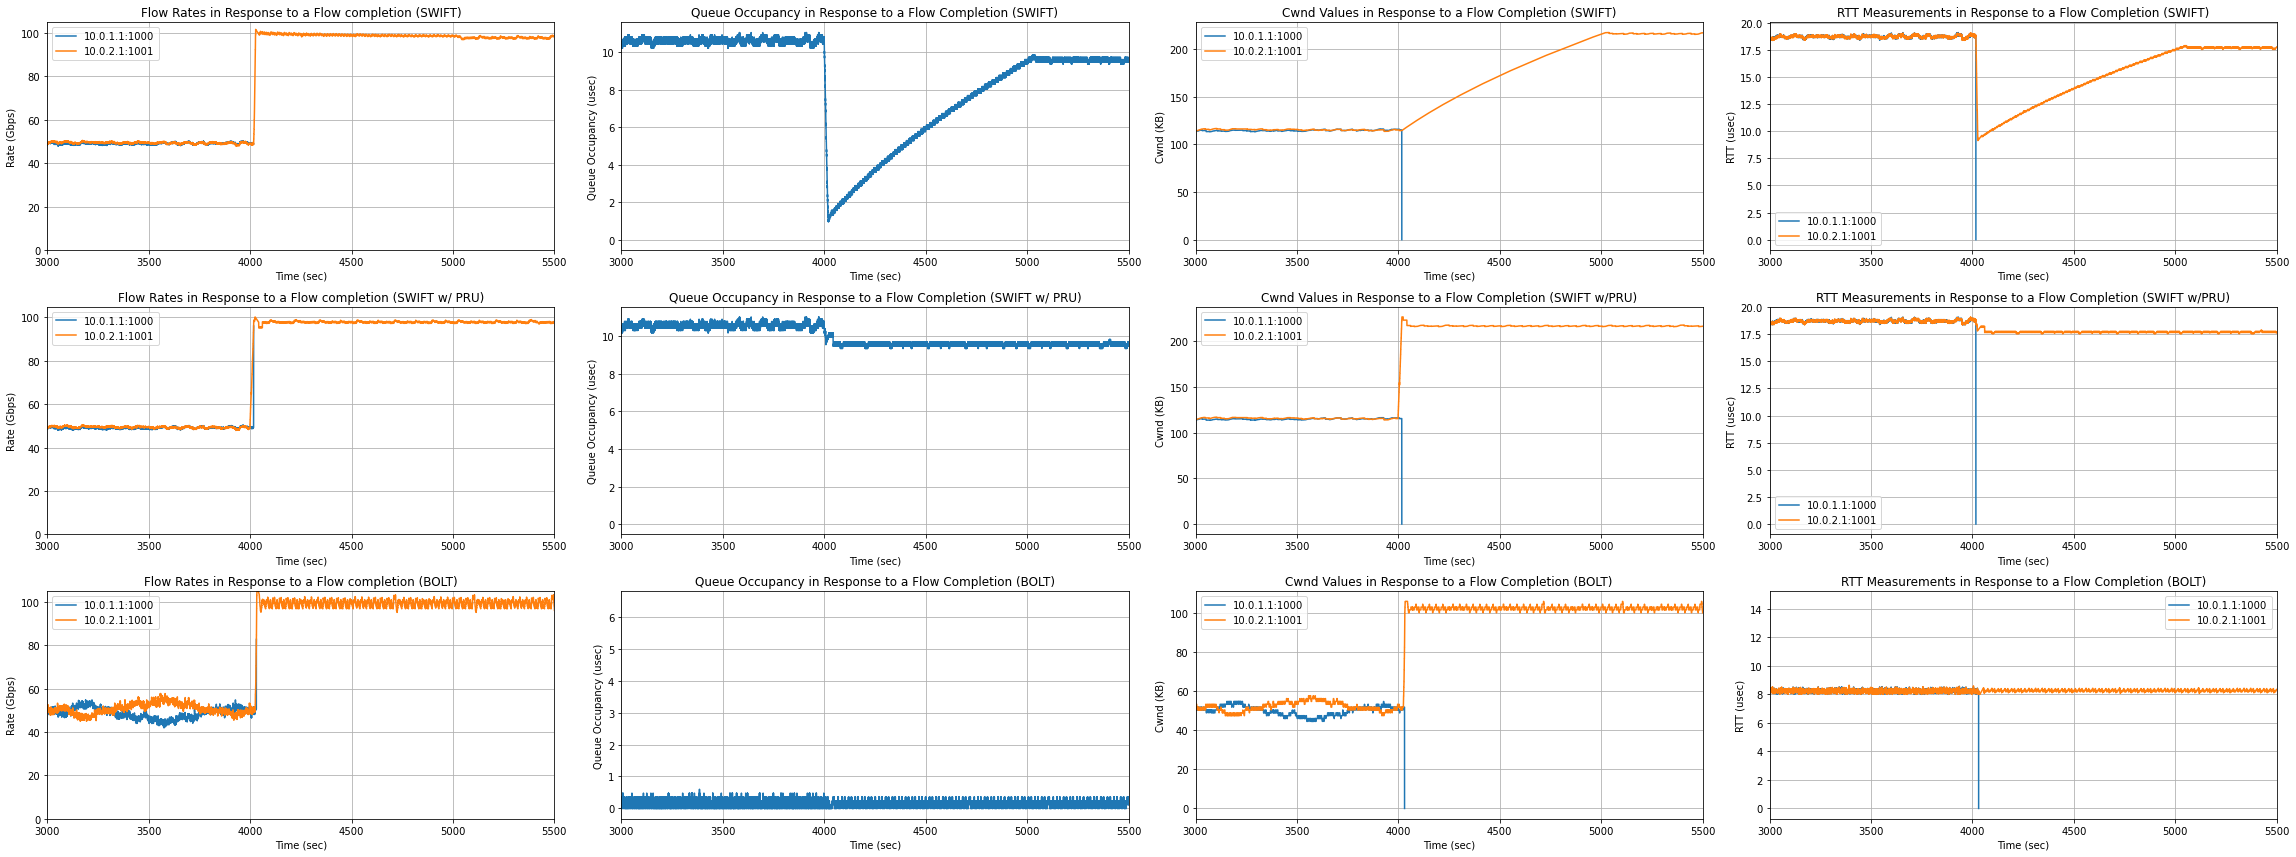

In [ ]:
#@title
plt.figure(figsize=(32,12))

#####

plt.subplot(3,4,1)
for sender, stats in swift_flow_stats.items():
  plt.plot(stats['times'],stats['rates'],label=sender)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim(ylim_rates)

plt.legend()
plt.grid()
plt.title('Flow Rates in Response to a Flow completion (SWIFT)')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()

#####

plt.subplot(3,4,5)
for sender, stats in swift_pru_flow_stats.items():
  plt.plot(stats['times'],stats['rates'],label=sender)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim(ylim_rates)

plt.legend()
plt.grid()
plt.title('Flow Rates in Response to a Flow completion (SWIFT w/ PRU)')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()

#####

plt.subplot(3,4,9)
for sender, stats in bolt_flow_stats.items():
  plt.plot(stats['times'],stats['rates'],label=sender)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim(ylim_rates)

plt.legend()
plt.grid()
plt.title('Flow Rates in Response to a Flow completion (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()

#####

plt.subplot(3,4,2)
plt.plot(swift_qlog['times'],swift_qlog['q_sizes'])

if xlim is not None:
  plt.xlim(xlim)

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Completion (SWIFT)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.tight_layout()

#####

plt.subplot(3,4,6)
plt.plot(swift_pru_qlog['times'],swift_pru_qlog['q_sizes'])

if xlim is not None:
  plt.xlim(xlim)

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Completion (SWIFT w/ PRU)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.tight_layout()

#####

plt.subplot(3,4,10)
plt.plot(bolt_qlog['times'],bolt_qlog['q_sizes'])

if xlim is not None:
  plt.xlim(xlim)

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Completion (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.tight_layout()

#####

plt.subplot(3,4,3)
for sender, stats in swift_flow_stats.items():
  plt.plot(stats['times'],stats['cwnds'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('Cwnd Values in Response to a Flow Completion (SWIFT)')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (KB)')
plt.tight_layout()

#####

plt.subplot(3,4,7)
for sender, stats in swift_pru_flow_stats.items():
  plt.plot(stats['times'],stats['cwnds'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('Cwnd Values in Response to a Flow Completion (SWIFT w/PRU)')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (KB)')
plt.tight_layout()

#####

plt.subplot(3,4,11)
for sender, stats in bolt_flow_stats.items():
  plt.plot(stats['times'],stats['cwnds'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('Cwnd Values in Response to a Flow Completion (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (KB)')
plt.tight_layout()

#####

plt.subplot(3,4,4)
for sender, stats in swift_flow_stats.items():
  plt.plot(stats['times'],stats['rtts'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('RTT Measurements in Response to a Flow Completion (SWIFT)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()

#####

plt.subplot(3,4,8)
for sender, stats in swift_pru_flow_stats.items():
  plt.plot(stats['times'],stats['rtts'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('RTT Measurements in Response to a Flow Completion (SWIFT w/PRU)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()

#####

plt.subplot(3,4,12)
for sender, stats in bolt_flow_stats.items():
  plt.plot(stats['times'],stats['rtts'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('RTT Measurements in Response to a Flow Completion (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()
plt.show()

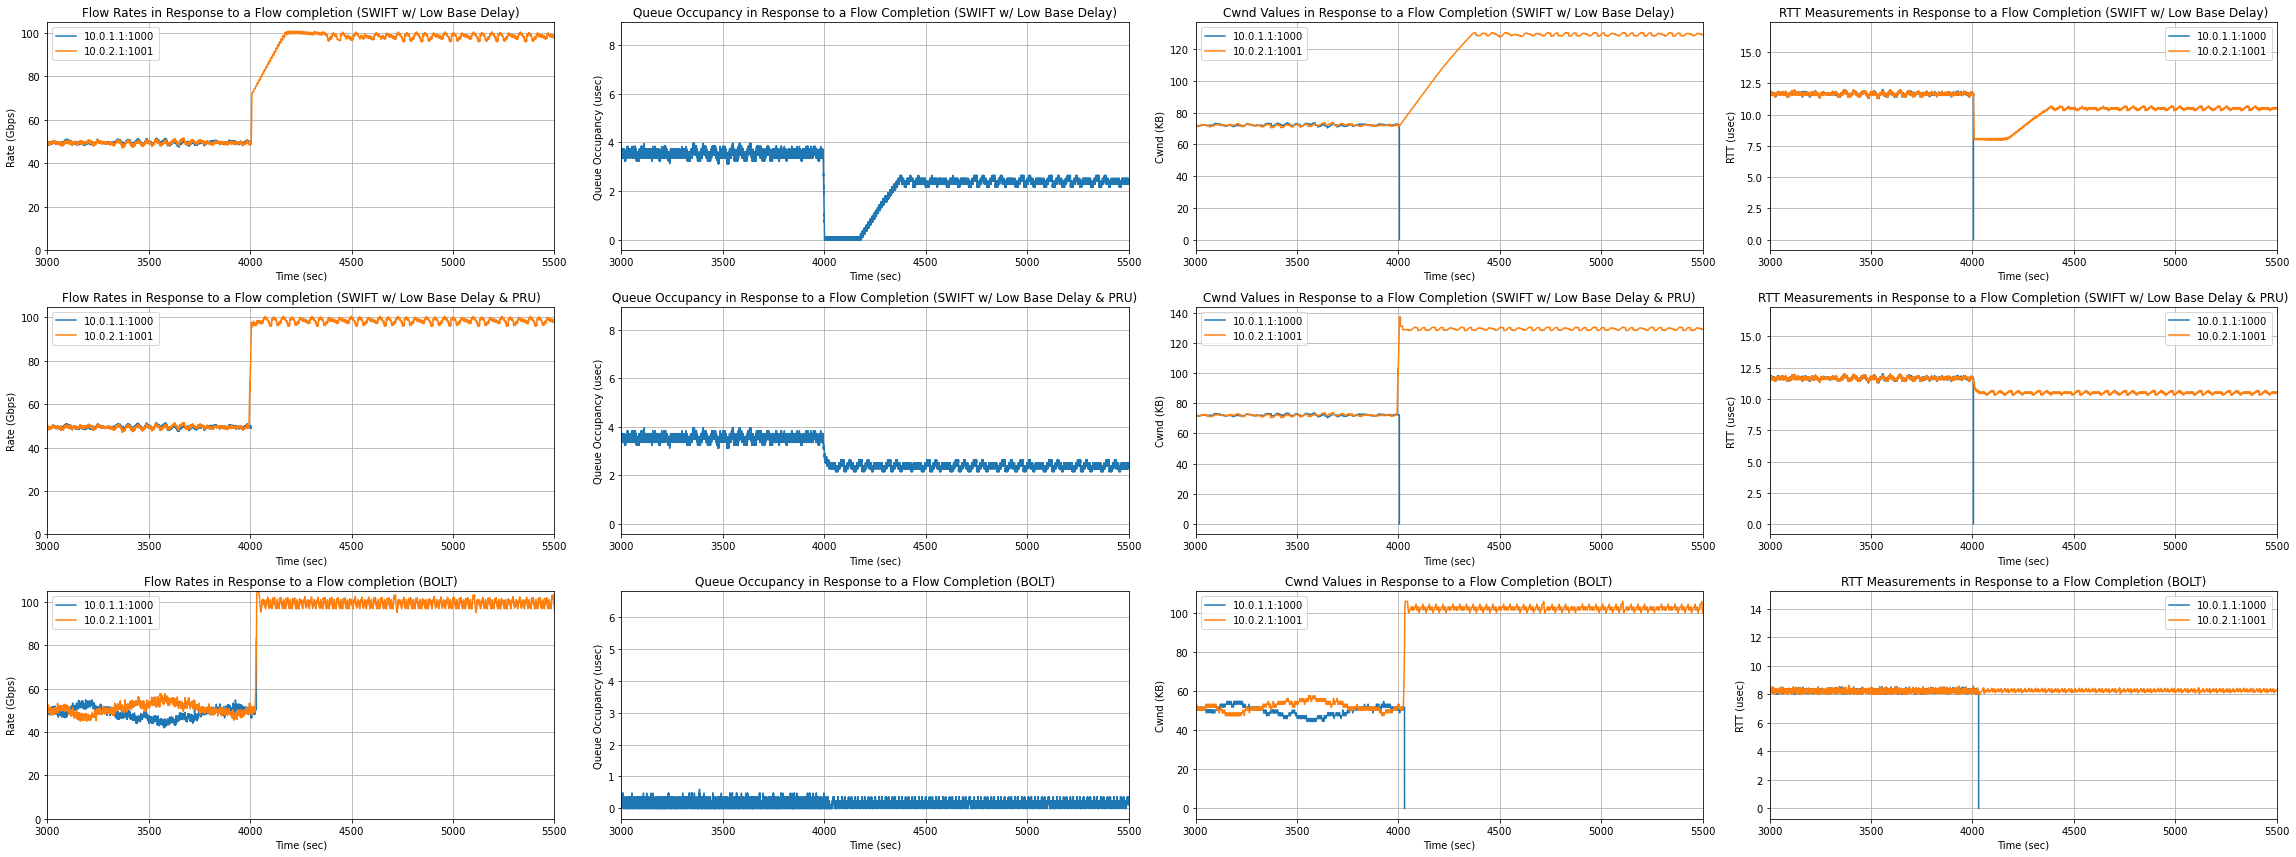

In [ ]:
#@title
plt.figure(figsize=(32,12))

#####

plt.subplot(3,4,1)
for sender, stats in swift_lowBase_flow_stats.items():
  plt.plot(stats['times'],stats['rates'],label=sender)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim(ylim_rates)

plt.legend()
plt.grid()
plt.title('Flow Rates in Response to a Flow completion (SWIFT w/ Low Base Delay)')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()

#####

plt.subplot(3,4,5)
for sender, stats in swift_lowBase_pru_flow_stats.items():
  plt.plot(stats['times'],stats['rates'],label=sender)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim(ylim_rates)

plt.legend()
plt.grid()
plt.title('Flow Rates in Response to a Flow completion (SWIFT w/ Low Base Delay & PRU)')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()

#####

plt.subplot(3,4,9)
for sender, stats in bolt_flow_stats.items():
  plt.plot(stats['times'],stats['rates'],label=sender)

if xlim is not None:
  plt.xlim(xlim)
plt.ylim(ylim_rates)

plt.legend()
plt.grid()
plt.title('Flow Rates in Response to a Flow completion (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Rate (Gbps)')
plt.tight_layout()

#####

plt.subplot(3,4,2)
plt.plot(swift_lowBase_qlog['times'],swift_lowBase_qlog['q_sizes'])

if xlim is not None:
  plt.xlim(xlim)

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Completion (SWIFT w/ Low Base Delay)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.tight_layout()

#####

plt.subplot(3,4,6)
plt.plot(swift_lowBase_pru_qlog['times'],swift_lowBase_pru_qlog['q_sizes'])

if xlim is not None:
  plt.xlim(xlim)

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Completion (SWIFT w/ Low Base Delay & PRU)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.tight_layout()

#####

plt.subplot(3,4,10)
plt.plot(bolt_qlog['times'],bolt_qlog['q_sizes'])

if xlim is not None:
  plt.xlim(xlim)

plt.grid()
plt.title('Queue Occupancy in Response to a Flow Completion (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.tight_layout()

#####

plt.subplot(3,4,3)
for sender, stats in swift_lowBase_flow_stats.items():
  plt.plot(stats['times'],stats['cwnds'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('Cwnd Values in Response to a Flow Completion (SWIFT w/ Low Base Delay)')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (KB)')
plt.tight_layout()

#####

plt.subplot(3,4,7)
for sender, stats in swift_lowBase_pru_flow_stats.items():
  plt.plot(stats['times'],stats['cwnds'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('Cwnd Values in Response to a Flow Completion (SWIFT w/ Low Base Delay & PRU)')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (KB)')
plt.tight_layout()

#####

plt.subplot(3,4,11)
for sender, stats in bolt_flow_stats.items():
  plt.plot(stats['times'],stats['cwnds'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('Cwnd Values in Response to a Flow Completion (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('Cwnd (KB)')
plt.tight_layout()

#####

plt.subplot(3,4,4)
for sender, stats in swift_lowBase_flow_stats.items():
  plt.plot(stats['times'],stats['rtts'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('RTT Measurements in Response to a Flow Completion (SWIFT w/ Low Base Delay)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()

#####

plt.subplot(3,4,8)
for sender, stats in swift_lowBase_pru_flow_stats.items():
  plt.plot(stats['times'],stats['rtts'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('RTT Measurements in Response to a Flow Completion (SWIFT w/ Low Base Delay & PRU)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()

#####

plt.subplot(3,4,12)
for sender, stats in bolt_flow_stats.items():
  plt.plot(stats['times'],stats['rtts'],label=sender)

if xlim is not None:
  plt.xlim(xlim)

plt.legend()
plt.grid()
plt.title('RTT Measurements in Response to a Flow Completion (BOLT)')
plt.xlabel('Time (sec)')
plt.ylabel('RTT (usec)')
plt.tight_layout()
plt.show()

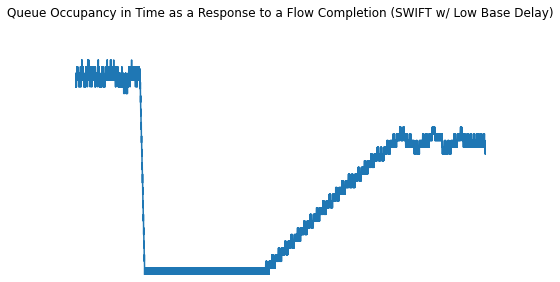

In [ ]:
#@title
plt.figure()
plt.plot(swift_lowBase_qlog['times'],swift_lowBase_qlog['q_sizes'])

plt.ylim([0,4.5])
plt.xlim([0.0039*1e6,0.0045*1e6])

plt.grid()
plt.title('Queue Occupancy in Time as a Response to a Flow Completion (SWIFT w/ Low Base Delay)')
plt.xlabel('Time (sec)')
plt.ylabel('Queue Occupancy (usec)')
plt.axis('off')
plt.tight_layout()
plt.show()

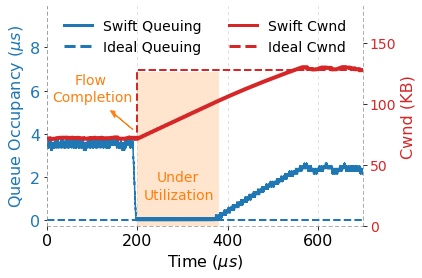

In [ ]:
#@title
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

color = 'C0'
ax1.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
ax1.set_ylabel('Queue Occupancy ($\\mu s$)', color=color, fontsize=FONTSIZE)
ln1 = ax1.plot([t-swift_lowBase_completion_time for t in swift_lowBase_qlog['times']],
         swift_lowBase_qlog['q_sizes'], color=color, label='Swift Queuing')
ln2 = ax1.axhline(y=0, color=color, linestyle='--', label='Ideal Queuing', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE)
ax1.tick_params(axis='x', labelsize=FONTSIZE)

label_color = 'C1'
ax1.text(60, 6.3, 'Flow', color=label_color, fontsize=FONTSIZE-2)
ax1.text(10, 5.5, 'Completion', color=label_color, fontsize=FONTSIZE-2)
plt.arrow(190, 4.2, -40, 0.7, head_width=0.3, color=label_color, head_length=10)
ax1.text(242, 1.8, 'Under', color=label_color, fontsize=FONTSIZE-2)
ax1.text(214, 1.0, 'Utilization', color=label_color, fontsize=FONTSIZE-2)
ax1.axvspan(200, 380, ymax=0.7, facecolor=label_color, alpha=.2)
ax1.set_ylim((-0.25, 9.9))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'C3'
ax2.set_ylabel('Cwnd (KB)', color=color, fontsize=FONTSIZE)
for sender, stats in swift_lowBase_flow_stats.items():
  if(sender == '10.0.2.1:1001'):
    ln3 = ax2.plot([t-swift_lowBase_completion_time for t in stats['times']]
             ,stats['cwnds'], color=color, label='Swift Cwnd', linewidth=4)
ln4 = ax2.plot([0, 200, 200, 800], [72, 72, 128, 128], '--', color=color, 
               label='Ideal Cwnd', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE-2)
ax2.set_ylim((0, 180))

lns = ln1+[ln2]+ln3+ln4
labs = [l.get_label() for l in lns]
leg= ax2.legend(lns, labs, loc='upper center', frameon=False, 
                fontsize=FONTSIZE-2, bbox_to_anchor=(0.5, 1.0), ncol=2)
for line in leg.get_lines():
    line.set_linewidth(3)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax2.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
plt.xlim(FIG_XLIM)

ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (SAVE_FIG):
  plt.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/swift_slow_rampup.pdf')
plt.show()

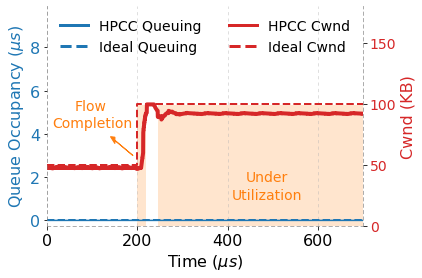

In [ ]:
#@title
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

color = 'C0'
ax1.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
ax1.set_ylabel('Queue Occupancy ($\\mu s$)', color=color, fontsize=FONTSIZE)
ln1 = ax1.plot([t-hpcc_completion_time for t in hpcc_qlog['q_times']],
               hpcc_qlog['q_sizes'], color=color, label='HPCC Queuing')
ln2 = ax1.axhline(y=0, color=color, linestyle='--', label='Ideal Queuing', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE)
ax1.tick_params(axis='x', labelsize=FONTSIZE)

label_color = 'C1'
ax1.text(60, 5.1, 'Flow', color=label_color, fontsize=FONTSIZE-2)
ax1.text(10, 4.3, 'Completion', color=label_color, fontsize=FONTSIZE-2)
plt.arrow(190, 3.0, -40, 0.7, head_width=0.3, color=label_color, head_length=10)
ax1.axvspan(200, 220, ymax=0.55, facecolor=label_color, alpha=.2)
ax1.text(440, 1.8, 'Under', color=label_color, fontsize=FONTSIZE-2)
ax1.text(410, 1.0, 'Utilization', color=label_color, fontsize=FONTSIZE-2)
ax1.axvspan(245, 800, ymax=0.55, facecolor=label_color, alpha=.2)
ax1.set_ylim((-0.25, 9.9))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'C3'
ax2.set_ylabel('Cwnd (KB)', color=color, fontsize=FONTSIZE)
for sender, stats in hpcc_flow_stats.items():
  if(sender == '0x25f5350'):
    ln3 = ax2.plot([t-hpcc_completion_time for t in stats['times']],
                   stats['cwnds'], color=color, label='HPCC Cwnd', linewidth=4)
ln4 = ax2.plot([0, 200, 200, 800], [50, 50, 100, 100], '--', color=color, 
               label='Ideal Cwnd', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE-2)
ax2.set_ylim((0, 180))

lns = ln1+[ln2]+ln3+ln4
labs = [l.get_label() for l in lns]
leg= ax2.legend(lns, labs, loc='upper center', frameon=False, 
                fontsize=FONTSIZE-2, bbox_to_anchor=(0.5, 1.0), ncol=2)
for line in leg.get_lines():
    line.set_linewidth(3)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax2.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
plt.xlim(FIG_XLIM)

ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (SAVE_FIG):
  plt.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/hpcc_slow_rampup.pdf')
plt.show()

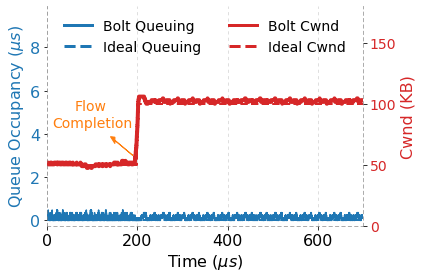

In [ ]:
#@title
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

color = 'C0'
ax1.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
ax1.set_ylabel('Queue Occupancy ($\\mu s$)', color=color, fontsize=FONTSIZE)
ln1 = ax1.plot([t-bolt_completion_time for t in bolt_qlog['times']],
                bolt_qlog['q_sizes'], color=color, label='Bolt Queuing')
ln2 = ax1.axhline(y=0, color=color, linestyle='--', label='Ideal Queuing', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE)
ax1.tick_params(axis='x', labelsize=FONTSIZE)

label_color = 'C1'
ax1.text(60, 5.1, 'Flow', color=label_color, fontsize=FONTSIZE-2)
ax1.text(10, 4.3, 'Completion', color=label_color, fontsize=FONTSIZE-2)
plt.arrow(190, 3.0, -40, 0.7, head_width=0.3, color=label_color, head_length=10)
ax1.set_ylim((-0.25, 9.9))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'C3'
ax2.set_ylabel('Cwnd (KB)', color=color, fontsize=FONTSIZE)
for sender, stats in bolt_flow_stats.items():
  if(sender == '10.0.2.1:1001'):
    ln3 = ax2.plot([t-bolt_completion_time for t in stats['times']]
             ,stats['cwnds'], color=color, label='Bolt Cwnd', linewidth=4)
ln4 = ax2.plot([0, 200, 200, 800], [50, 50, 100, 100], '--', color=color, 
               label='Ideal Cwnd', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE-2)
ax2.set_ylim((0, 180))

lns = ln1+[ln2]+ln3+ln4
labs = [l.get_label() for l in lns]
leg= ax2.legend(lns, labs, loc='upper center', frameon=False, fontsize=FONTSIZE-2,
           bbox_to_anchor=(0.5, 1.0), ncol=2)
for line in leg.get_lines():
    line.set_linewidth(3)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax2.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
plt.xlim(FIG_XLIM)

ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (SAVE_FIG):
  plt.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/bolt_pru_rampup.pdf')
plt.show()

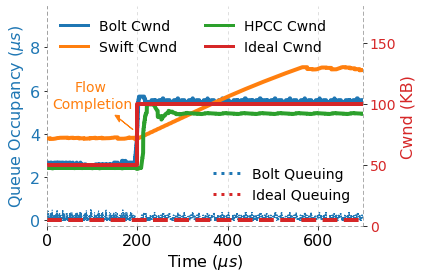

In [ ]:
#@title
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

color = 'C0'
ax1.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
ax1.set_ylabel('Queue Occupancy ($\\mu s$)', color=color, fontsize=FONTSIZE)
ln1 = ax1.plot([t-bolt_completion_time for t in bolt_qlog['times']],
                bolt_qlog['q_sizes'], ':', color='C0', label='Bolt Queuing', linewidth=1)
ln2 = ax1.axhline(y=0, color='C3', linestyle='--', label='Ideal Queuing', linewidth=4)
ax1.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE)
ax1.tick_params(axis='x', labelsize=FONTSIZE)

label_color = 'C1'
ax1.text(60, 6.0, 'Flow', color=label_color, fontsize=FONTSIZE-2)
ax1.text(10, 5.2, 'Completion', color=label_color, fontsize=FONTSIZE-2)
plt.arrow(190, 4.2, -30, 0.5, head_width=0.3, color=label_color, head_length=10)
ax1.set_ylim((-0.25, 9.9))

leg1 = ax1.legend(loc='lower right', frameon=False, 
                  bbox_to_anchor=(1.0, 0.05), fontsize=FONTSIZE-2, ncol=1)
for line in leg1.get_lines():
  line.set_linestyle(':')
  line.set_linewidth(3)

ax1.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax1.spines['top'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

ax = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'C3'

ax.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
ax.tick_params(axis='x', labelsize=FONTSIZE)
ax.set_ylabel('Cwnd (KB)', color=color, fontsize=FONTSIZE)
ax.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE-2)

for sender, stats in bolt_flow_stats.items():
  if(sender == '10.0.2.1:1001'):
    ax.plot([t-bolt_completion_time for t in stats['times']],
            stats['cwnds'], color='C0', label='Bolt Cwnd', linewidth=4)
for sender, stats in swift_lowBase_flow_stats.items():
  if(sender == '10.0.2.1:1001'):
    ax.plot([t-swift_lowBase_completion_time for t in stats['times']],
            stats['cwnds'], color='C1', label='Swift Cwnd', linewidth=4)
for sender, stats in hpcc_flow_stats.items():
  if(sender == '0x25f5350'):
    ax.plot([t-hpcc_completion_time for t in stats['times']],
            stats['cwnds'], color='C2', label='HPCC Cwnd', linewidth=4)
ax.plot([0, 200, 200, 800], [50, 50, 100, 100], color='C3', 
        label='Ideal Cwnd', linewidth=4)

ax.set_ylim((0, 160))
ax.set_ylim((0, 180))

leg= ax.legend(loc='upper left', frameon=False, fontsize=FONTSIZE-2, ncol=2)
for line in leg.get_lines():
    line.set_linewidth(3)

ax.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax.spines['top'].set_visible(False)
ax.spines["right"].set_linestyle(LINE_STYLE)
ax.spines["right"].set_alpha(0.5)
ax.spines["right"].set_color('gray')
ax.spines["left"].set_linestyle(LINE_STYLE)
ax.spines["left"].set_alpha(0.5)
ax.spines["left"].set_color('gray')
ax.spines["bottom"].set_linestyle(LINE_STYLE)
ax.spines["bottom"].set_alpha(0.5)
ax.spines["bottom"].set_color('gray')

plt.xlim(FIG_XLIM)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (SAVE_FIG):
  plt.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/all_rampup.pdf')
plt.show()

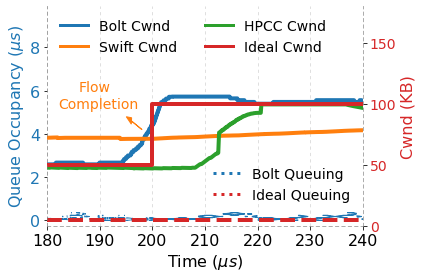

In [ ]:
#@title
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

color = 'C0'
ax1.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
ax1.set_ylabel('Queue Occupancy ($\\mu s$)', color=color, fontsize=FONTSIZE)
ln1 = ax1.plot([t-bolt_completion_time for t in bolt_qlog['times']],
                bolt_qlog['q_sizes'], ':', color='C0', label='Bolt Queuing', linewidth=1)
ln2 = ax1.axhline(y=0, color='C3', linestyle='--', label='Ideal Queuing', linewidth=4)
ax1.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE)
ax1.tick_params(axis='x', labelsize=FONTSIZE)

label_color = 'C1'
ax1.text(186, 6.0, 'Flow', color=label_color, fontsize=FONTSIZE-2)
ax1.text(182, 5.2, 'Completion', color=label_color, fontsize=FONTSIZE-2)
plt.arrow(198, 4.2, -2, 0.4, head_width=0.3, color=label_color, head_length=1)
ax1.set_ylim((-0.25, 9.9))

leg1 = ax1.legend(loc='lower right', frameon=False, 
                  bbox_to_anchor=(1.0, 0.05), fontsize=FONTSIZE-2, ncol=1)
for line in leg1.get_lines():
  line.set_linestyle(':')
  line.set_linewidth(3)

ax1.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax1.spines['top'].set_visible(False)
ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')

ax = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'C3'

ax.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
ax.tick_params(axis='x', labelsize=FONTSIZE)
ax.set_ylabel('Cwnd (KB)', color=color, fontsize=FONTSIZE)
ax.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE-2)

for sender, stats in bolt_flow_stats.items():
  if(sender == '10.0.2.1:1001'):
    ax.plot([t-bolt_completion_time for t in stats['times']],
            stats['cwnds'], color='C0', label='Bolt Cwnd', linewidth=4)
for sender, stats in swift_lowBase_flow_stats.items():
  if(sender == '10.0.2.1:1001'):
    ax.plot([t-swift_lowBase_completion_time for t in stats['times']],
            stats['cwnds'], color='C1', label='Swift Cwnd', linewidth=4)
for sender, stats in hpcc_flow_stats.items():
  if(sender == '0x25f5350'):
    ax.plot([t-hpcc_completion_time for t in stats['times']],
            stats['cwnds'], color='C2', label='HPCC Cwnd', linewidth=4)
ax.plot([0, 200, 200, 800], [50, 50, 100, 100], color='C3', 
        label='Ideal Cwnd', linewidth=4)

ax.set_ylim((0, 160))
ax.set_ylim((0, 180))

leg= ax.legend(loc='upper left', frameon=False, fontsize=FONTSIZE-2, ncol=2)
for line in leg.get_lines():
    line.set_linewidth(3)

ax.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax.spines['top'].set_visible(False)
ax.spines["right"].set_linestyle(LINE_STYLE)
ax.spines["right"].set_alpha(0.5)
ax.spines["right"].set_color('gray')
ax.spines["left"].set_linestyle(LINE_STYLE)
ax.spines["left"].set_alpha(0.5)
ax.spines["left"].set_color('gray')
ax.spines["bottom"].set_linestyle(LINE_STYLE)
ax.spines["bottom"].set_alpha(0.5)
ax.spines["bottom"].set_color('gray')

plt.xlim((COMPLETION_TIME-20,COMPLETION_TIME+40))
fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (SAVE_FIG):
  plt.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/all_rampup_zoom.pdf')
plt.show()

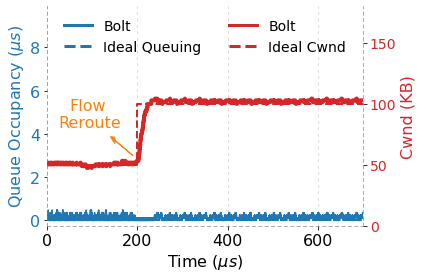

In [ ]:
#@title
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

color = 'C0'
ax1.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
ax1.set_ylabel('Queue Occupancy ($\\mu s$)', color=color, fontsize=FONTSIZE)
ln1 = ax1.plot([t-bolt_noPru_completion_time for t in bolt_noPru_qlog['times']],
                bolt_noPru_qlog['q_sizes'], color=color, label='Bolt')
ln2 = ax1.axhline(y=0, color=color, linestyle='--', label='Ideal Queuing', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE)
ax1.tick_params(axis='x', labelsize=FONTSIZE)

label_color = 'C1'
ax1.text(50, 5.1, 'Flow', color=label_color, fontsize=FONTSIZE)
ax1.text(25, 4.3, 'Reroute', color=label_color, fontsize=FONTSIZE)
plt.arrow(190, 3.0, -40, 0.7, head_width=0.3, color=label_color, head_length=10)
ax1.set_ylim((-0.25, 9.9))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'C3'
ax2.set_ylabel('Cwnd (KB)', color=color, fontsize=FONTSIZE)
for sender, stats in bolt_noPru_flow_stats.items():
  if(sender == '10.0.2.1:1001'):
    ln3 = ax2.plot([t-bolt_noPru_completion_time for t in stats['times']]
             ,stats['cwnds'], color=color, label='Bolt', linewidth=4)
ln4 = ax2.plot([0, 200, 200, 800], [50, 50, 100, 100], '--', color=color, 
               label='Ideal Cwnd', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE-2)
ax2.set_ylim((0, 180))

lns = ln1+[ln2]+ln3+ln4
labs = [l.get_label() for l in lns]
leg= ax2.legend(lns, labs, loc='upper center', frameon=False, fontsize=FONTSIZE-2,
           bbox_to_anchor=(0.5, 1.0), ncol=2)
for line in leg.get_lines():
    line.set_linewidth(3)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax2.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
plt.xlim(FIG_XLIM)

ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (SAVE_FIG):
  plt.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/bolt_sm_rampup.pdf')
plt.show()

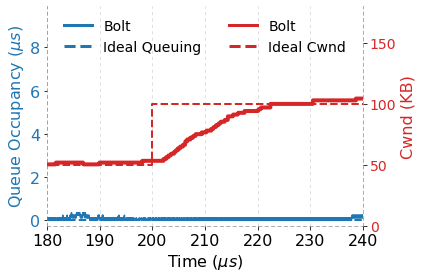

In [ ]:
#@title
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

color = 'C0'
ax1.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
ax1.set_ylabel('Queue Occupancy ($\\mu s$)', color=color, fontsize=FONTSIZE)
ln1 = ax1.plot([t-bolt_noPru_completion_time for t in bolt_noPru_qlog['times']],
                bolt_noPru_qlog['q_sizes'], color=color, label='Bolt')
ln2 = ax1.axhline(y=0, color=color, linestyle='--', label='Ideal Queuing', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE)
ax1.tick_params(axis='x', labelsize=FONTSIZE)

label_color = 'C1'
# ax1.text(50, 5.1, 'Flow', color=label_color, fontsize=FONTSIZE)
# ax1.text(25, 4.3, 'Reroute', color=label_color, fontsize=FONTSIZE)
# plt.arrow(190, 3.0, -40, 0.7, head_width=0.3, color=label_color, head_length=10)
ax1.set_ylim((-0.25, 9.9))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'C3'
ax2.set_ylabel('Cwnd (KB)', color=color, fontsize=FONTSIZE)
for sender, stats in bolt_noPru_flow_stats.items():
  if(sender == '10.0.2.1:1001'):
    ln3 = ax2.plot([t-bolt_noPru_completion_time for t in stats['times']]
             ,stats['cwnds'], color=color, label='Bolt', linewidth=4)
ln4 = ax2.plot([0, 200, 200, 800], [50, 50, 100, 100], '--', color=color, 
               label='Ideal Cwnd', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE-2)
ax2.set_ylim((0, 180))

lns = ln1+[ln2]+ln3+ln4
labs = [l.get_label() for l in lns]
leg= ax2.legend(lns, labs, loc='upper center', frameon=False, fontsize=FONTSIZE-2,
           bbox_to_anchor=(0.5, 1.0), ncol=2)
for line in leg.get_lines():
    line.set_linewidth(3)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax2.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
plt.xlim((COMPLETION_TIME-20,COMPLETION_TIME+40))

ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

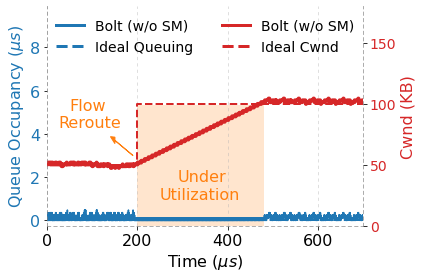

In [ ]:
#@title
fig, ax1 = plt.subplots(figsize=FIG_SIZE)

color = 'C0'
ax1.set_xlabel('Time ($\\mu s$)', fontsize=FONTSIZE)
ax1.set_ylabel('Queue Occupancy ($\\mu s$)', color=color, fontsize=FONTSIZE)
ln1 = ax1.plot([t-bolt_noPru_noSm_completion_time for t in bolt_noPru_noSm_qlog['times']],
                bolt_noPru_noSm_qlog['q_sizes'], color=color, label='Bolt (w/o SM)')
ln2 = ax1.axhline(y=0, color=color, linestyle='--', label='Ideal Queuing', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE)
ax1.tick_params(axis='x', labelsize=FONTSIZE)

label_color = 'C1'
ax1.text(50, 5.1, 'Flow', color=label_color, fontsize=FONTSIZE)
ax1.text(25, 4.3, 'Reroute', color=label_color, fontsize=FONTSIZE)
plt.arrow(190, 3.0, -40, 0.7, head_width=0.3, color=label_color, head_length=10)
ax1.text(290, 1.8, 'Under', color=label_color, fontsize=FONTSIZE)
ax1.text(250, 1.0, 'Utilization', color=label_color, fontsize=FONTSIZE)
ax1.axvspan(200, 480, ymax=0.55, facecolor=label_color, alpha=.2)
ax1.set_ylim((-0.25, 9.9))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'C3'
ax2.set_ylabel('Cwnd (KB)', color=color, fontsize=FONTSIZE)
for sender, stats in bolt_noPru_noSm_flow_stats.items():
  if(sender == '10.0.2.1:1001'):
    ln3 = ax2.plot([t-bolt_noPru_noSm_completion_time for t in stats['times']]
             ,stats['cwnds'], color=color, label='Bolt (w/o SM)', linewidth=4)
ln4 = ax2.plot([0, 200, 200, 800], [50, 50, 100, 100], '--', color=color, 
               label='Ideal Cwnd', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color, labelsize=FONTSIZE-2)
ax2.set_ylim((0, 180))

lns = ln1+[ln2]+ln3+ln4
labs = [l.get_label() for l in lns]
leg= ax2.legend(lns, labs, loc='upper center', frameon=False, fontsize=FONTSIZE-2,
           bbox_to_anchor=(0.5, 1.0), ncol=2)
for line in leg.get_lines():
    line.set_linewidth(3)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
ax2.grid(axis='x', alpha=0.5, linestyle=LINE_STYLE)
plt.xlim(FIG_XLIM)

ax1.spines["right"].set_linestyle(LINE_STYLE)
ax1.spines["right"].set_alpha(0.5)
ax1.spines["right"].set_color('gray')
ax1.spines["left"].set_linestyle(LINE_STYLE)
ax1.spines["left"].set_alpha(0.5)
ax1.spines["left"].set_color('gray')
ax1.spines["top"].set_linestyle(LINE_STYLE)
ax1.spines["top"].set_alpha(0.5)
ax1.spines["top"].set_color('gray')
ax1.spines["bottom"].set_linestyle(LINE_STYLE)
ax1.spines["bottom"].set_alpha(0.5)
ax1.spines["bottom"].set_color('gray')
ax2.spines["right"].set_linestyle(LINE_STYLE)
ax2.spines["right"].set_alpha(0.5)
ax2.spines["right"].set_color('gray')
ax2.spines["left"].set_linestyle(LINE_STYLE)
ax2.spines["left"].set_alpha(0.5)
ax2.spines["left"].set_color('gray')
ax2.spines["top"].set_linestyle(LINE_STYLE)
ax2.spines["top"].set_alpha(0.5)
ax2.spines["top"].set_color('gray')
ax2.spines["bottom"].set_linestyle(LINE_STYLE)
ax2.spines["bottom"].set_alpha(0.5)
ax2.spines["bottom"].set_color('gray')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (SAVE_FIG):
  plt.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/bolt_noPru_noSm_rampup.pdf')
plt.show()